
# Supplemental Information

This notebook is intended to serve as a supplement to the manuscript "High-throughput workflows for determining adsorption energies on solid surfaces."  It outlines basic use of the code and workflow software that has been developed for processing surface slabs and placing adsorbates according to symmetrically distinct sites on surface facets.

## Example 1: AdsorbateSiteFinder (pymatgen)

An example using the the AdsorbateSiteFinder class in pymatgen is shown below.  We begin with an import statement for the necessay modules.  To use the MP RESTful interface, you must provide your own API key either in the MPRester call i.e. ```mpr=MPRester("YOUR_API_KEY")``` or provide in in your .pmgrc.yaml configuration file.  API keys can be accessed at materialsproject.org under your "Dashboard."

In [ ]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19 atomate

In [ ]:
# Import statements
from __future__ import annotations

from matplotlib import pyplot as plt
from pymatgen.analysis.adsorption import *
from pymatgen.core import Lattice, Molecule, Structure
from pymatgen.core.surface import generate_all_slabs
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

%matplotlib inline
# Note that you must provide your own API Key, which can
# be accessed via the Dashboard at materialsproject.org
mpr = MPRester()

We create a simple fcc structure, generate it's distinct slabs, and select the slab with a miller index of (1, 1, 1).

In [ ]:
fcc_ni = Structure.from_spacegroup("Fm-3m", Lattice.cubic(3.5), ["Ni"], [[0, 0, 0]])
slabs = generate_all_slabs(fcc_ni, max_index=1, min_slab_size=8.0, min_vacuum_size=10.0)
ni_111 = [slab for slab in slabs if slab.miller_index == (1, 1, 1)][0]

We make an instance of the AdsorbateSiteFinder and use it to find the relevant adsorption sites.

In [ ]:
asf_ni_111 = AdsorbateSiteFinder(ni_111)
ads_sites = asf_ni_111.find_adsorption_sites()
print(ads_sites)
assert len(ads_sites) == 4

{'ontop': [array([1.23743687, 0.71443451, 9.0725408 ])], 'bridge': [array([-0.61871843,  1.78608627,  9.0725408 ])], 'hollow': [array([-1.93768867e-15,  1.42886902e+00,  9.07254080e+00]), array([1.23743687, 2.14330352, 9.0725408 ])], 'all': [array([1.23743687, 0.71443451, 9.0725408 ]), array([-0.61871843,  1.78608627,  9.0725408 ]), array([-1.93768867e-15,  1.42886902e+00,  9.07254080e+00]), array([1.23743687, 2.14330352, 9.0725408 ])]}


We visualize the sites using a tool from pymatgen.

<Axes: >

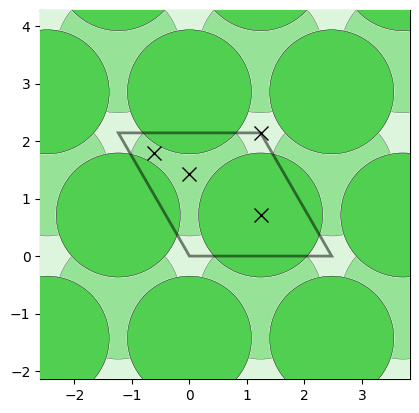

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_slab(ni_111, ax, adsorption_sites=True)

Use the `AdsorbateSiteFinder.generate_adsorption_structures` method to generate structures of adsorbates.

/Users/shyue/miniconda3/envs/mavrl/lib/python3.11/site-packages/pymatgen/core/structure.py:1051: UserWarning: Not all sites have property bulk_wyckoff. Missing values are set to None.
  warnings.warn(f"Not all sites have property {key}. Missing values are set to None.")
/Users/shyue/miniconda3/envs/mavrl/lib/python3.11/site-packages/pymatgen/core/structure.py:1051: UserWarning: Not all sites have property bulk_equivalent. Missing values are set to None.
  warnings.warn(f"Not all sites have property {key}. Missing values are set to None.")


<Axes: >

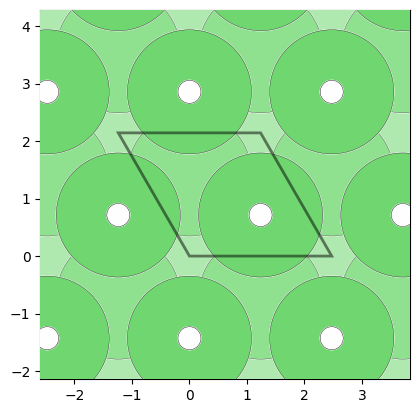

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
adsorbate = Molecule("H", [[0, 0, 0]])
ads_structs = asf_ni_111.generate_adsorption_structures(adsorbate, repeat=[1, 1, 1])
plot_slab(ads_structs[0], ax, adsorption_sites=False, decay=0.09)

## Example 2: AdsorbateSiteFinder for various surfaces

In this example, the AdsorbateSiteFinder is used to find adsorption sites on different structures and miller indices.

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

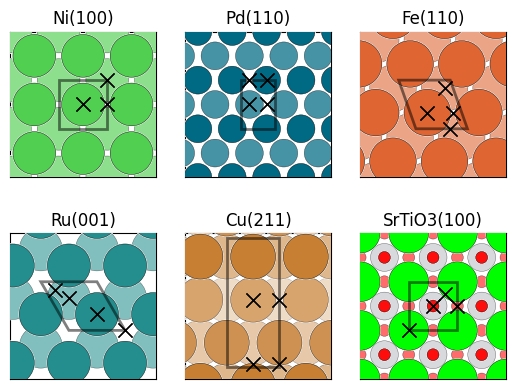

In [ ]:
fig = plt.figure()
axes = [fig.add_subplot(2, 3, i) for i in range(1, 7)]
mats = {
    "mp-23": (1, 0, 0),  # FCC Ni
    "mp-2": (1, 1, 0),  # FCC Au
    "mp-13": (1, 1, 0),  # BCC Fe
    "mp-33": (0, 0, 1),  # HCP Ru
    "mp-30": (2, 1, 1),
    "mp-5229": (1, 0, 0),
}  # Cubic SrTiO3
# "mp-2133":(0, 1, 1)} # Wurtzite ZnO

for n, (mp_id, m_index) in enumerate(mats.items()):
    struct = mpr.get_structure_by_material_id(mp_id)
    struct = SpacegroupAnalyzer(struct).get_conventional_standard_structure()
    slabs = generate_all_slabs(struct, 1, 5.0, 2.0, center_slab=True)
    slab_dict = {slab.miller_index: slab for slab in slabs}
    asf = AdsorbateSiteFinder.from_bulk_and_miller(
        struct, m_index, undercoord_threshold=0.10
    )
    plot_slab(asf.slab, axes[n])
    ads_sites = asf.find_adsorption_sites()
    sop = get_rot(asf.slab)
    ads_sites = [sop.operate(ads_site)[:2].tolist() for ads_site in ads_sites["all"]]
    axes[n].plot(
        *zip(*ads_sites),
        color="k",
        marker="x",
        markersize=10,
        mew=1,
        linestyle="",
        zorder=10000,
    )
    mi_string = "".join([str(i) for i in m_index])
    axes[n].set_title(f"{struct.composition.reduced_formula}({mi_string})")
    axes[n].set_xticks([])
    axes[n].set_yticks([])

axes[4].set_xlim(-2, 5)
axes[4].set_ylim(-2, 5)
fig.savefig("slabs.png", dpi=200)